# Species Classification - SVM Model

## About Dataset

The Iris flower dataset is one of the most popular ones for machine learning. More information can be found [here](https://en.wikipedia.org/wiki/Iris_flower_data_set).

## Import Libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

## Load Iris Dataset

In [2]:
iris_data = datasets.load_iris()

In [3]:
# Assign petal length and petal width to variable X
X = iris_data["data"][:, 2:] # petal length, petal width

In [4]:
# Variable y contains only iris virginica
y = (iris_data["target"] == 2).astype(np.float64)

## Build Pipeline with StandardScaler and LinearSVC

In [5]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
])
svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

### Use the Model to Make Predictions

In [6]:
svm_clf.predict([[3.5, 2.5]])

array([1.])

Unlike the logistic regressin the SVM classifiers do not return probabilities.

## Plot Classification Using Large and Small Hyperparameter C

In [7]:
# Build a models for hyperparameters C=1 and C=100
scaler = StandardScaler()
svm_clf_1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf_2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf_1 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf_1)
])
scaled_svm_clf_2 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf_2)
])

scaled_svm_clf_1.fit(X, y)
scaled_svm_clf_2.fit(X, y)

C:\Users\ttomk\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [8]:
# Convert to unscaled parameters
b1 = svm_clf_1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf_2.decision_function([-scaler.mean_ / scaler.scale_])

w1 = svm_clf_1.coef_[0] / scaler.scale_
w2 = svm_clf_2.coef_[0] / scaler.scale_

svm_clf_1.intercept_ = np.array([b1])
svm_clf_2.intercept_ = np.array([b2])

svm_clf_1.coef_ = np.array([w1])
svm_clf_2.coef_ = np.array([w2])

In [9]:
# Find support vectors
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()

svm_clf_1.support_vectors_ = X[support_vectors_idx1]
svm_clf_2.support_vectors_ = X[support_vectors_idx2]

(4.0, 5.9, 0.8, 2.8)

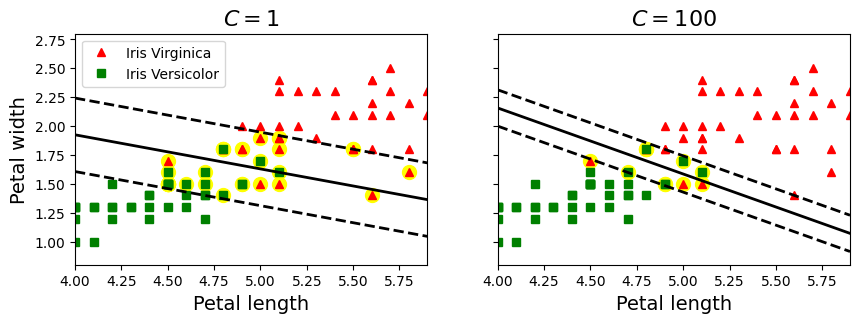

In [10]:
# Plot classifiers
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    
    # At the decision bourdary, w0*x0 + w1*x1 + b = 0 => x1 = -w0/w1*x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
    margin = 1 / w[1]
    up = decision_boundary + margin
    down = decision_boundary - margin
    
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=100, facecolors="yellow")
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, up, "k--", linewidth=2)
    plt.plot(x0, down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,3), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "r^", label="Iris Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "gs", label="Iris Versicolor")
plot_svc_decision_boundary(svm_clf_1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.title("$C = {}$".format(svm_clf_1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "r^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "gs")
plot_svc_decision_boundary(svm_clf_2, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf_2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

The model with hyperparameter C=1 has a lot of margin violations but it will generalize better.

## Compare Linear SVC, SVC, and SGDClassifier

From iris dataset use Iris Setosa and Iris Versicolor classes that are linearly separable to get `LinearSVC`, `SVC`, and `SGDClassifier` to produce similar models.

In [11]:
# Select Iris Setosa and Iris Versicolor
y = iris_data["target"]

setosa_or_versicolor = (y==0) | (y==1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [12]:
# Train all three classifiers
C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha, max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC: ", lin_clf.intercept_, lin_clf.coef_)
print("SVC: ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier: ", sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:  [0.28475098] [[1.05364854 1.09903804]]
SVC:  [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier:  [0.117] [[0.77714169 0.72981762]]


Plot decision boundaries for all three models

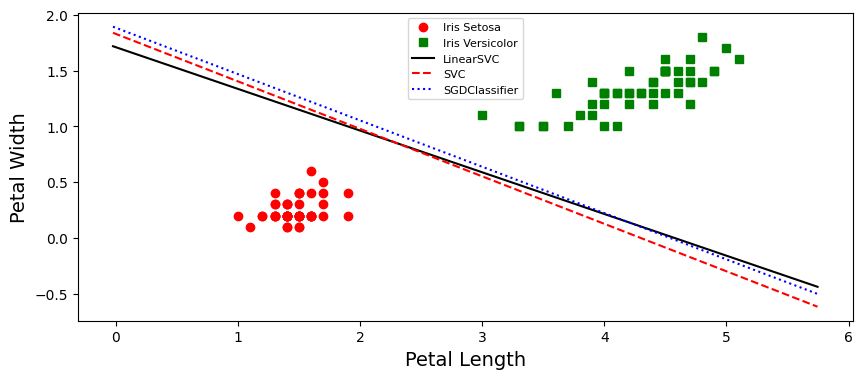

In [13]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0] / lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0] / lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0] / svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0] / svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0] / sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0] / sgd_clf.coef_[0, 1]

# Transform decision boundary lines to the original scale
line1 = scaler.inverse_transform([[-2, -2 * w1 + b1], [2, 2 * w1 + b1]])
line2 = scaler.inverse_transform([[-2, -2 * w2 + b2], [2, 2 * w2 + b2]])
line3 = scaler.inverse_transform([[-2, -2 * w3 + b3], [2, 2 * w3 + b3]])

# Plot all decision boundaries
plt.figure(figsize=(10, 4))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Iris Setosa")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "gs", label="Iris Versicolor")
plt.plot(line1[:, 0], line1[:, 1], "k-", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "r--", label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "b:", label="SGDClassifier")
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal Width", fontsize=14)
plt.legend(loc="upper center", fontsize=8)
plt.show()

## Decision Tree Classifer

In [23]:
# Train Decision Tree Classifier
X = iris_data["data"][:, 2:]
y = iris_data["target"]
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

Visualize the trained Decision Tree using the `export_graphviz` method.

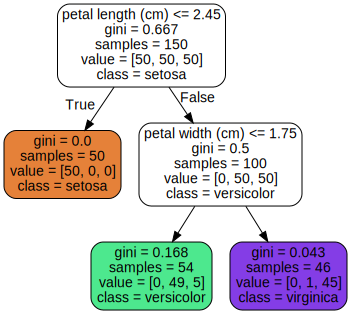

In [24]:
dot_data = export_graphviz(tree_clf, feature_names=iris_data.feature_names[2:], class_names=iris_data.target_names,
                out_file=None, rounded=True, filled=True)
graph = graphviz.Source(dot_data)
graph

### Make predictions

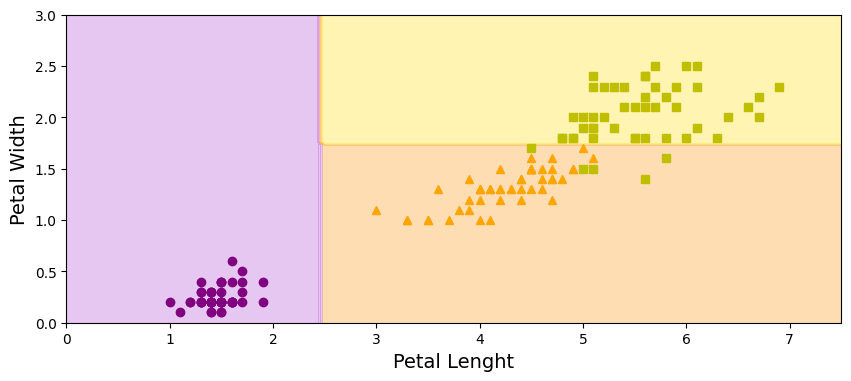

In [74]:
# Plot decision boundaries of Decision Tree Classifier
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], legend=False, plot_train=True):
    X1s = np.linspace(axes[0], axes[1], 100)
    X2s = np.linspace(axes[2], axes[3], 100)
    X1, X2 = np.meshgrid(X1s, X2s)
    X_new = np.c_[X1.ravel(), X2.ravel()]
    y_pred = clf.predict(X_new).reshape(X1.shape)
    custom_cmap = ListedColormap(["#AF47D2", "#FF8F00", "#FFDB00"])
    plt.contourf(X1, X2, y_pred, alpha=0.3, cmap=custom_cmap)
    plt.xlabel("Petal Lenght", fontsize=14)
    plt.ylabel("Petal Width", fontsize=14)
    if plot_train:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "o",color="purple", label="Iris Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "^", color="orange", label="Iris Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "ys", label="Iris Virginica")
        
plt.figure(figsize=(10, 4))
plot_decision_boundary(tree_clf, X, y)
plt.show()

Classification and Regression Tree (CART) algorithm is stochastic, and therefore, it can produce very different model every time when trained on the same data. By setting the `random_state` parameter to different value the model prediction changes.

In [64]:
tree_clf2 = DecisionTreeClassifier(max_depth=2, random_state=90)
tree_clf2.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=90)

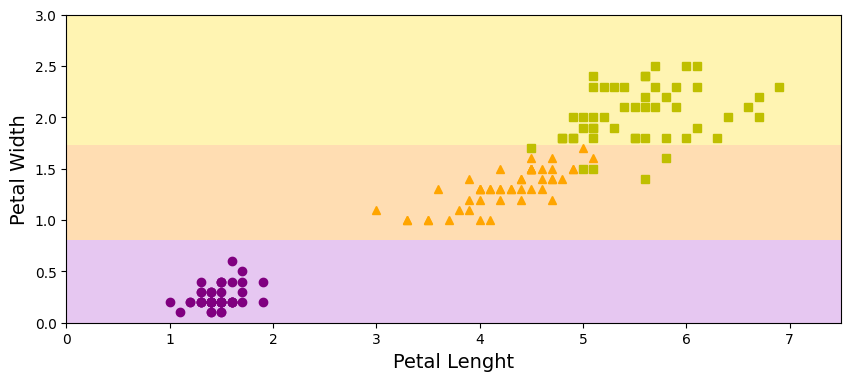

In [75]:
plt.figure(figsize=(10, 4))
plot_decision_boundary(tree_clf2, X, y)
plt.show()

Rotating the dataset leads to different decision boundaries.

In [72]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
X_rot = X.dot(rotation_matrix)

# Train decision tress on rotated dataset
tree_clf_rot = DecisionTreeClassifier(random_state=42)
tree_clf_rot.fit(X_rot, y)

DecisionTreeClassifier(random_state=42)

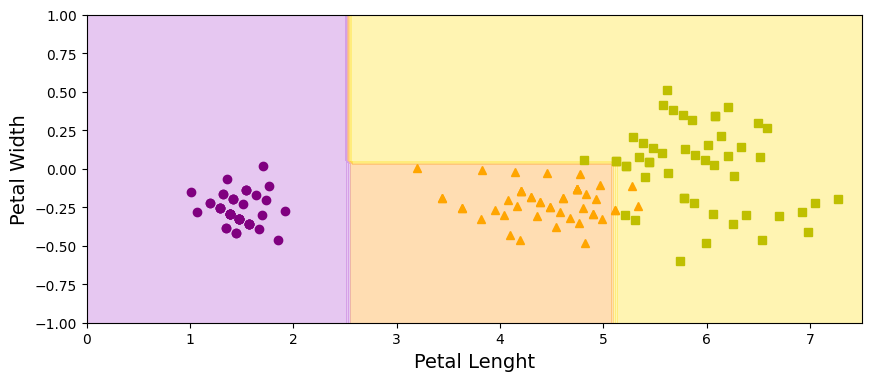

In [76]:
# Plot decision boundaries
plt.figure(figsize=(10, 4))
plot_decision_boundary(tree_clf_rot, X_rot, y, axes=[0, 7.5, -1, 1])
plt.show()